In [18]:
!pip3 install tensorflow
!pip3 install torchvision
!pip3 install torch
!pip3 install pandas
!pip3 install matplotlib

## Import packages and modules

In [19]:
# Imports
from collections import OrderedDict

import numpy as np
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)

from torchvision.transforms import transforms

from autoencoders.utils import *

2.2.2
0.17.2


## Load the CIFAR-10 dataset

In [20]:

# Define transform
transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

CIFAR_set = torchvision.datasets.CIFAR10(root='../data/CIFAR10', train=True,
                                         download=True, transform=transform)

test_set = torchvision.datasets.CIFAR10(root='../data/CIFAR10', train=False,
                                        download=True, transform=transform)

train_set, val_set = train_val_split(CIFAR_set, 0.1)

Files already downloaded and verified
Files already downloaded and verified


## Define residual block and autoencoder model

In [24]:
class SimpleAutoencoder(nn.Module):
    """
    Autoencoder class, combines encoder and decoder model.
    """
    
    def __init__(self):
        super(SimpleAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveMaxPool2d((16, 16)),  # Output is always 16x16
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveMaxPool2d((8, 8))  # Output is always 8x8
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## Training

In [26]:
param_names = ('init_lr', 'batch_size', 'weight_decay')
parameters = OrderedDict(
    run = [0.05, 256, 0.001],
)

In [27]:
m = RunManager()
num_epochs = 2

for hparams in RunBuilder.get_runs_from_params(param_names, parameters):

    # Instantiate a network model
    ae = SimpleAutoencoder()

    # Construct a DataLoader object with training data
    train_loader = DataLoader(train_set, batch_size=hparams.batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=hparams.batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=10, shuffle=False)
    test_images, _ = next(iter(test_loader))

    # Define optimizer
    optimizer = optim.SGD(ae.parameters(), lr=hparams.init_lr, momentum=0.9, weight_decay=hparams.weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, 60, 0.1)
    
    # Setup run instance
    m.begin_run(hparams, ae, test_images)
    print('Now training model with hyperparameters: init_lr={0}, batch_size={1}, weight_decay={2}'
         .format(hparams.init_lr, hparams.batch_size, hparams.weight_decay))
    
    # Start training loop
    for epoch in range(num_epochs):
        m.begin_epoch()
        
        # Train the model
        for i, batch in enumerate(train_loader):
            images, _ = batch
            
            # Zero all gradients
            optimizer.zero_grad()
            
            # Calculating the loss
            preds = ae(images)
            loss = F.mse_loss(preds, images)
            
            if i % 10 == 0:
                with torch.no_grad():
                    val_images, _ = next(iter(val_loader))
                    val_preds = ae(val_images)
                    val_loss = F.mse_loss(val_preds, val_images)
                    m.track_loss(val_loss, val_images.size(0), mode='val')
                print('Epoch {0}, iteration {1}: train loss {2}, val loss {3}'.format(epoch+1,
                                                                               i*hparams.batch_size,
                                                                               round(loss.item(), 6),
                                                                               round(val_loss.item(), 6)))
            
            # Backpropagate
            loss.backward()

            # Update the weights
            optimizer.step()
            
            m.track_loss(loss, images.size(0), mode='train')
            
        m.end_epoch()
    
    #torch.save(ae, './models/150epochs_' + str(hparams) + '.pth')
    m.end_run()
    print("Model has finished training.\n")
    scheduler.step()
    
m.save('results_final')
print("Training completed.")

,run,epoch,train loss,validation loss,epoch duration,run duration,init_lr,batch_size,weight_decay
0,1,1,0.222203,0.240228,174.962149,175.798387,0.05,256,0.001
1,1,2,0.097907,0.098067,216.378464,392.818084,0.05,256,0.001


Model has finished training.

Training completed.


<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

## Evaluate model performance

In [28]:
# Load best model
ae = torch.load('./models/best_Run(init_lr=0.05, batch_size=256, weight_decay=0.001).pth')

Visualising test images...

Original images:


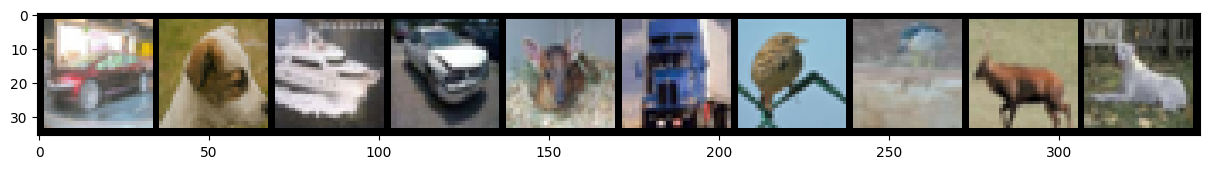

Reconstructed images:


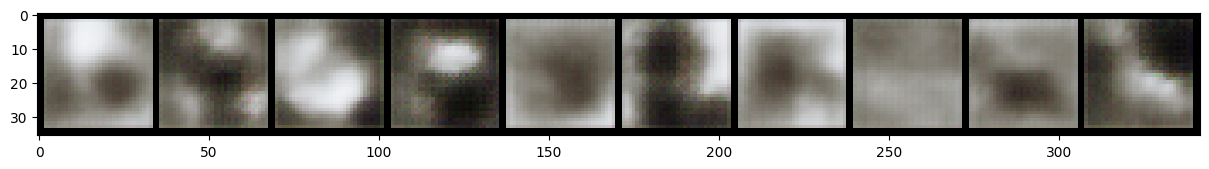

Test loss: 0.08552245050668716


In [29]:
print("Visualising test images...\n")

test_loader = DataLoader(test_set, batch_size=10, shuffle=True)
images, _ = next(iter(test_loader))
print("Original images:")
imgviz(images)
print("Reconstructed images:")
with torch.no_grad():
    preds = ae(images)
    imgviz(preds)
    
# Test loss
test_loader = DataLoader(test_set, batch_size=len(test_set))
for i, batch in enumerate(test_loader):
    images, _ = batch
    with torch.no_grad():
        preds = ae(images)
        loss = F.mse_loss(preds, images) # calculates the loss
print('Test loss:', loss.item())